In [1]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report
import numpy as np

2025-06-11 17:29:49.198610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749659389.212524 3250193 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749659389.216758 3250193 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749659389.227353 3250193 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749659389.227370 3250193 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749659389.227371 3250193 computation_placer.cc:177] computation placer alr

In [2]:
tf.__version__

'2.19.0'

# MODELO S

## 1 - Data Preprocessing

Caminhos dos sets

In [3]:
train_dir = 'dataset_balanceado_final/train'
validation_dir = 'dataset_balanceado_final/validation'
test_dir = 'dataset_balanceado_final/test'

Definir batch_size e image_size

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = 150
BATCH_SIZE = 32

Training set -  É o conjunto de dados usado para treinar a rede

In [5]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical' # categorical porque temos várias classes, senão seria binário (2 classes)
)

Found 4276 files belonging to 7 classes.


I0000 00:00:1749659391.667528 3250193 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4804 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:03:00.0, compute capability: 7.5
I0000 00:00:1749659391.671027 3250193 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 4804 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:05:00.0, compute capability: 7.5


Validation set - Usado para 'testar' o modelo durante o processo de procura da melhor combinação de hiperparâmetros.

In [6]:
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 1420 files belonging to 7 classes.


Test set - Usado para testar o modelo depois do processo de treino

In [7]:
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 1420 files belonging to 7 classes.


### Métricas para avaliar os modelos

In [8]:
# Utiliza uma função(do sckicit-learn) para avaliar o desempenho do modelo, indicando Métricas como: 
    # f1-score do modelo
    # accuracy do modelo
    # accuracy por classe 

from sklearn.metrics import classification_report
import numpy as np

def print_classification_metrics(model, dataset, phase_name):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    print(f"\n {phase_name}")
    print(classification_report(y_true, y_pred, digits=4))


## 2 - Construir a CNN (convolucional Neural Network) 

In [9]:
# Define a camada de entrada do modelo com o formato das imagens (altura, largura, 3 canais RGB).
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) 

In [10]:
# Normaliza os valores dos pixels das imagens de entrada para o intervalo [0, 1].
x = layers.Rescaling(1./255)(inputs)

### Passo 1 : Camada Convolucional

In [11]:
# Primeira camada convolucional com 64 filtros 3x3 e ativação ReLU
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x) 
# adicionado o padding="same" para garantir que o output da camada convolucional tem a mesma dimensão espacial (altura e largura) que o input, após a operação de convolução.

### Passo 2 : Camada de Pooling

In [12]:
# Primeira camada de pooling máximo (2x2) para reduzir a dimensionalidade.
x = layers.MaxPooling2D(pool_size=2)(x)

### Passo 3 : Adicionar mais camadas 

In [13]:
# Segunda camada convolucional com 128 filtros 3x3 e ativação ReLU.
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
# Segunda camada de pooling máximo (2x2).
x = layers.MaxPooling2D(pool_size=2)(x)

In [14]:
# Terceira camada convolucional com 128 filtros 3x3 e ativação ReLU.
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
# Terceira camada de pooling máximo (2x2).
x = layers.MaxPooling2D(pool_size=2)(x)

### Passo 4 : Flattening 

In [15]:
# Achata o output das camadas convolucionais para um vetor 1D.
x = layers.Flatten()(x)

BATCH NORMALIZATION  (Facultativo)

In [16]:
# tirar comentario desta linha abaixo se queremos usar batch normalization
# porem foi testado varias vezes e em diferentes camadas da rede, mas não melhorou o desempenho do modelo (e o optuna tambem sugeriu nao utilizar)
#x = layers.BatchNormalization( axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,beta_initializer="zeros",    moving_mean_initializer="zeros", moving_variance_initializer="ones")(x)

#### Dropout (facultativo) - funçao de regularização

In [17]:
# Aplica Dropout (50%) para desativar aleatoriamente neurónios, prevenindo o overfitting.
x = layers.Dropout(0.5)(x)

### Passo 5 : Full Connection

In [18]:
# Definir funçao de Regularização L2 (opcional)
reg = regularizers.l2(0.01)  # Executar para ativar

# Camada densa (totalmente conectada) com 128 neurónios, ativação ReLU e funçao de regularizaçao L2
x = layers.Dense(128, activation="relu", kernel_regularizer=reg)(x)

### Passo 6 : Output Layer

In [19]:
# Camada de saída densa com 7 neurónios e ativação Softmax (para classificação categórica).
outputs = layers.Dense(7, activation="softmax")(x) 

In [20]:
# Cria o modelo Keras usando as camadas de entrada e saída definidas.
model = keras.Model(inputs=inputs, outputs=outputs)

## 3 - Treinar a rede CNN 

#### Funções de otimização disponíveis: Adam, RMSprop e SGD

#### Funções de loss disponíveis: categorical_crossentropy    ,    KLDivergence e MSE 

In [21]:
# Configura o otimizador Adam 
# Define a função de loss: Categorical crossentropy
# Indica que a 'accuracy' (precisão) será a métrica durante o treino.
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [22]:
#model.compile(
    #optimizer='SGD', 
    #loss='mse',
    #metrics=['accuracy'])

In [23]:
#model.compile(
    #optimizer=tf.keras.optimizers.RMSprop(),
    #loss=tf.keras.losses.KLDivergence(),
    #metrics=['accuracy'])

### Treinar o modelo

In [24]:
history = model.fit(
    train_dataset, #Inicia o treino do modelo usando o conjunto de dados de treino.
    epochs=25,     # O modelo será treinado por 25 épocas (passagens completas pelo conjunto de treino).
    validation_data=validation_dataset) # Usa o conjunto de dados de validação para monitorizar o desempenho do modelo em dados não vistos durante o treino.

Epoch 1/25


I0000 00:00:1749659394.358268 3250257 service.cc:152] XLA service 0x7d6ee8007b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749659394.358289 3250257 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
I0000 00:00:1749659394.358293 3250257 service.cc:160]   StreamExecutor device (1): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-06-11 17:29:54.391709: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749659394.568763 3250257 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-11 17:29:54.906468: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.9 = (f32[32,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,150,150]{3,2,1,0} %bitcast.4962, 

  3/134 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.1406 - loss: 4.5533

I0000 00:00:1749659398.514552 3250257 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2006 - loss: 2.6475

2025-06-11 17:30:07.387108: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.9 = (f32[20,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,150,150]{3,2,1,0} %bitcast.4962, f32[64,3,3,3]{3,2,1,0} %bitcast.4750, f32[64]{0} %bitcast.5305), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_1/convolution" source_file="/home/eliana/escola/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-11 17:30:07.479720: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted 

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2009 - loss: 2.6440

2025-06-11 17:30:10.679415: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.9 = (f32[32,64,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,150,150]{3,2,1,0} %bitcast.572, f32[64,3,3,3]{3,2,1,0} %bitcast.579, f32[64]{0} %bitcast.581), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_1/convolution" source_file="/home/eliana/escola/venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-11 17:30:10.762703: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted pot

134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.2012 - loss: 2.6406 - val_accuracy: 0.3761 - val_loss: 1.7970
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.3649 - loss: 1.8279 - val_accuracy: 0.3824 - val_loss: 1.7203
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.4562 - loss: 1.5968 - val_accuracy: 0.5014 - val_loss: 1.5018
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.4565 - loss: 1.5350 - val_accuracy: 0.4937 - val_loss: 1.5870
Epoch 5/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.4896 - loss: 1.4763 - val_accuracy: 0.4859 - val_loss: 1.5297
Epoch 6/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.5064 - loss: 1.4565 - val_accuracy: 0.5239 - val_loss: 1.4166
Epoch 7/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.5205 - loss: 1.4138 - val_accuracy: 0.5204 - val_loss: 1.4242
Epoch 8/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.5267 - loss: 1.3934 - val_accura

## 4 - Testar o modelo

In [25]:
print_classification_metrics(model, test_dataset, "Modelo 1 : CNN de raiz")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━

2025-06-11 17:34:22.390662: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Ver as Curvas de Loss e de Accuracy

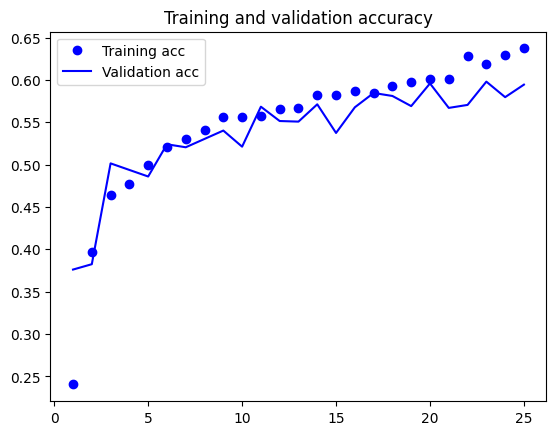

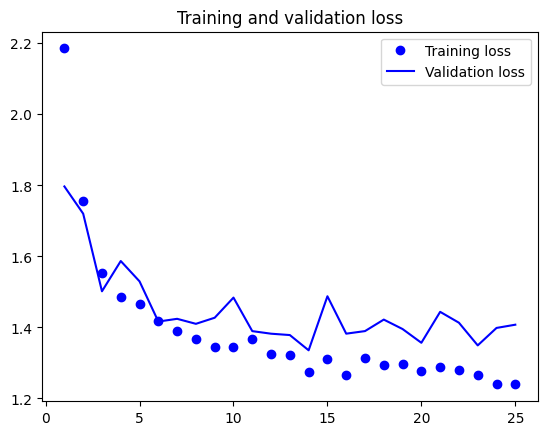

In [29]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Este modelo mostra um comportamento estável e constante. As curvas acompanham-se bem, não há sinais de overfitting, e o número de épocas parece adequado. O treino está a ser bem aproveitado.

### Matriz de confusão

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

2025-06-11 17:43:00.429192: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1000x800 with 0 Axes>

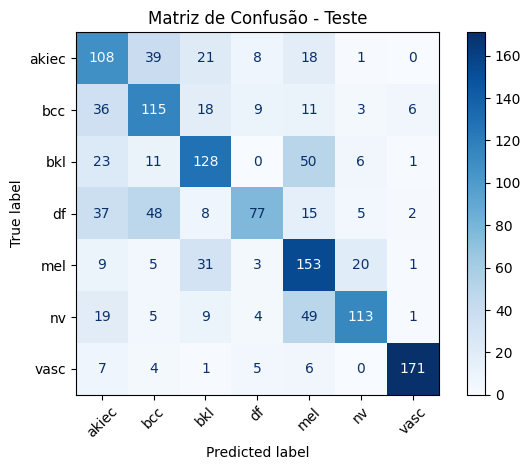

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obter predições no test_dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

class_names = test_dataset.class_names  

# Criar e mostrar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, values_format='d')
plt.title("Matriz de Confusão - Teste")
plt.tight_layout()
plt.show()

A matriz apresenta valores altos na diagonal, refletindo boa precisão nas predições corretas. As confusões entre df, bcc e akiec sugerem que o modelo tem mais dificuldade em distinguir lesões com aparência semelhante.

## Salvar o modelo 

In [31]:
model.save("modelS_2A_sem_data_aug_Adam.keras")